In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import json
import os

In [2]:
from cleaning import *
from etl import *
from eda import *

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

# Cleaning & Descriptive Stats

In assignment 1, the data ingestion design kept the following columns for the data pre- 2018:
- stop_id
- stop_cause
- date_stop
- time_stop
- sd_resident
- service_area
- subject_sex
- arrested
- searched
- obtained_consent
- contraband_found
- property_seized
    
For post- 2018, the columns kept were:
 - stop_id
 - stop_cause
 - date_stop
 - time_stop
 - stopduration
 - beat
 - service_area
 - race code
 - gend
 - officer_assignment_key
 - exp_years
 - perceived_age

For the remainder of this assignment, the data we will look at will be from 2015. 

In [4]:
test = get_table(2015)

To assess the quality of the data and justify the cleaning, I looked at the null values and data types.

 For null values, I looked specifically at age and columns that had to do with 'post stop outcomes'. 

In [5]:
null_dist(test, ['searched', 'obtained_consent', 'contraband_found', 'property_seized', 'arrested'])

,searched,obtained_consent,contraband_found,property_seized,arrested
% Null,0.08177,0.949273,0.946899,0.947263,0.076545


According to the data schema, these columns are conditionally null. I.e. obtained_consent, contraband_found, and property_seized will all be null if no search is conducted.

For data types, I looked mostly at which columns were appropiate to map to boolean values.

In [6]:
test.dtypes

stop_id              int64
stop_cause          object
service_area        object
subject_race        object
subject_sex         object
subject_age         object
date_time           object
date_stop           object
time_stop           object
sd_resident         object
arrested            object
searched            object
obtained_consent    object
contraband_found    object
property_seized     object
dtype: object

I observed that most of the data types were 'objects' or strings. However, most of these would be better off as numerical (1 or 0) or boolean values for easier analysis. I decided to change to boolean the followign columns:
- service_area
- subject_age
- sd_resdient
- arrested
- searched
- obtained_consent
- contraband_found
- property_seized

Other columns I looked more closly at were race, age, and time.

#### Observations for Race 

Accuracy Issuss:
- possible misidentifying a subset of people uniformly over time

Precision Issues:
- not a uniform way to identify bi-racial people

##### Age:
Right away it was clear that there would be some accuracy and precision issues with age.

In [7]:
test.subject_age.unique()

array([nan, '26', '40', '37', '29', '23', '24', '31', '60', '54', '42',
       '50', '30', '22', '41', '27', '48', '20', '28', '34', '44', '21',
       '49', '25', '58', '45', '59', '66', '64', '47', '32', '63', '52',
       '57', '70', '35', '19', '68', '55', '62', '65', '53', '46', '38',
       '75', '43', '74', '97', '79', '72', '16', '76', '39', '18', '17',
       '61', '56', '51', '36', '33', '77', '73', '83', '5', '71', '67',
       '69', '81', '78', '90', '213', '80', '222', '84', '88', '85', '0',
       '4', '82', '99', '91', '89', '6', '87', '7', '15', '86', '1', '2_',
       '93', '3', '8', '4_', 'No Age', '1020', 'y', '223', 'f', '345',
       'h', '125', '3.7', 'j', '3_', '243', '224', '399', 'f26', '32`',
       '13', '14', '9', '11', 'x', '92', '55Q', 'F48', '456', '2005', '`',
       '233', '96', '701', '387', '180', 'f28', 'Y', 'NN', '10', '173',
       '2', '98', '94', '100'], dtype=object)

In [8]:
new_age = pd.to_numeric(test.subject_age, errors='coerce').dropna()

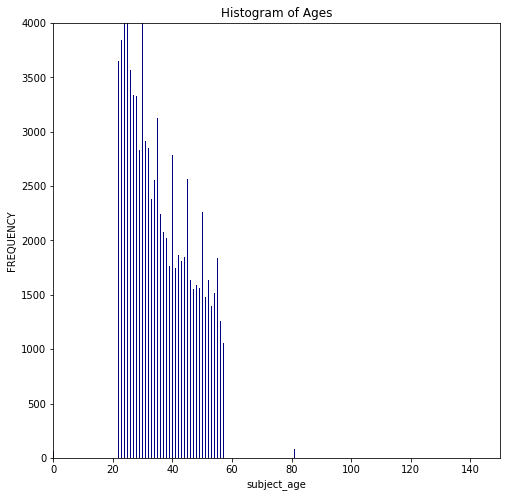

In [9]:
make_hist(new_age, 'Histogram of Ages', 'subject_age')

##### Observations for Age:

Accuracy Issues:
- age was actually 'percieved age' and not exact

Precision Issues:
- values spikes every 5 years becasue of human guessing bias

##### Time:

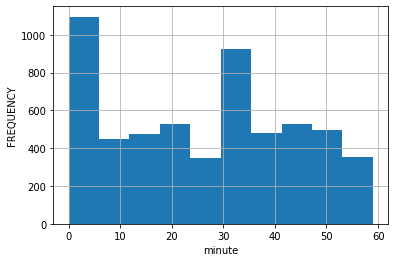

In [10]:
plot_minute(test)

#### Observations for Time

Precision Issues:
- values spikes every hour, half hour, 10 minutes, and 5 minutes years becasue of human guessing bias
- this is especially impactful when dealing with the inter-twilight period because it is so time sensitive

#### Other Notable Cleaning Observations:

The remainder of the cleaning performed was done to make the format of the pre- 2018 data match the post- 2018 data. There were differences in the possible values for gender/ sex and race for the different years that had to be mapped and renammed. The beats in the post- 2018 data were mapped to the service areas accordingly. And several columns were conbined to create and 'outcome' variable for each year. The possible values I decided to create were: 'Arrested', 'Property was seized', 'Search of property was conducted', and 'Not Applicable'. The remainder of the possible outcomes made up a small amout of the data but I didnt drop them (just labeled as 'Not Applicable') becasue I did not want lose the data.

In pre- 2018, I used to following columns to create outcome: ‘Arrested’, ‘Property_Seized’, and ‘Searched’ 

In post- 2018, I filtered the ‘action’ and ‘result’ columns to create outcome. 

##### Cleaned Data

Once the initial cleaning was done, I chose to assess the relative columns: 'outcome', 'driver_race', and 'percieved_driver_age'

In [11]:
clean = get_data(2015)

Overall, the distribution of outcome was as follows

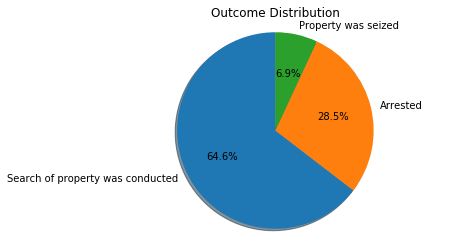

In [12]:
plot_outcomes(clean)

For the driver age, I decided to filter the values based on the value counts of that age. In other words, it replaced every 'age' that had less than 10 counts with a nan. This got rid of the ages that contained letters, were greater than 92, and were less than 10.

Cleaning driver_race was not too difficult. This was becasue the data generating process didn't create many nullor obscure values for race. The only difficulty was deciding how precise to make race identification. For example, the different years had different levels of detail for types of 'Asian' races. I decided to keep the most detailed race codes. 

For the 2015 data, the distribution of race is as follows:

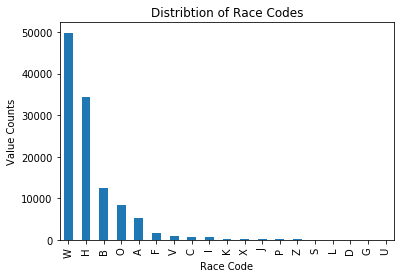

In [13]:
plot_races(clean)

In descending order, the top 5 most prevalent race codes are:
- W: white
- H: hispanic
- B: black
- O: other
- A: asian

# Traffic Stop Analysis: 

Our	statistical	analysis compare the following race categories of drivers:

• White

• Black	

• Hispanic

• Asian

##### Stop Rates

In [14]:
total_pop_2010 = 3095313

Using the total population of San Diego from the 2010 census, we see that the stop rates for White, Hispanic, Black , Other, and Asian drivers (respectively) are as follows:

In [15]:
get_stop_rates(clean)

,W,H,B,O,A
Stop Rates,0.016098,0.011121,0.004002,0.002751,0.001682


##### Post- Stop Outcomes

In [16]:
pd.DataFrame({'White': outcome_dist(clean, 'W').values, 'Black': outcome_dist(clean, 'B').values, 'Hispanic': outcome_dist(clean, 'H').values, 'Asian': outcome_dist(clean, 'A').values}, index = outcome_dist(clean, 'W').index).T

,Not Applicable,Search of property was conducted,Arrested,Property was seized
White,0.437481,0.262311,0.412946,0.266055
Black,0.102698,0.251149,0.160714,0.140673
Hispanic,0.294794,0.393959,0.334077,0.510703
Asian,0.046110,0.023309,0.022321,0.018349


##### Analysis: 

It is important to explore possible reasons for such differences, including addressing possible confounders. 

What may be causing these differences?

- Differential criminality
- Social and economic disadvantages
- “Bad Apple” police
- Widely shared but individually subtle differences in how white and majority drivers are treated following a traffic stop
- Implicit bias, consequence of years of exposure to associations in the environment 
- Institutional practices which lead to radical differences in outcomes

# Veil of Darkness:

The ‘Veil of Darkness’ technique attempts to examine the effect of the drivers’ race/ ethnicity f the likelihood that they will be pulled over. This technique assumes that officers who engage in racial profiling are less likely to see the drivers' race when it is dark out (i.e. low visibility).

Using this assumption, if stops during dark had a smaller proportion of minority drivers stopped than during light, it would be evidence of racial profiling.

The time period that is used to examine this effect is known as the ‘inter- twilights period’, the time between the earliest and latest civil twilight. In San Diego, for 2015, this was 5:09pm - 8:29pm.

In [19]:
inter_twilight = get_veil(clean);

In [18]:
get_stop_rates(inter_twilight)

,W,H,B,O,A
Stop Rates,0.00168,0.001378,0.000497,0.000345,0.000186


##### Result Notes on Interpretation:
Before making any causal assumptions, it is important to note some caveats to this technique. These include but are not limited to:

-	vehicle make, year, and model often correlate with race and are still visible at night, which could lead to the test under-estimating the extent of racial profiling
-	the influence of artificial lighting is not accounted for
-	and this technique is not necessarily comparable under the context of other hours of the day (i.e. it is not necessarily a representative sample)